# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

2. How is this task different from a SLAM problem?

Answer1. 
The fundamental idea of the problem beign proposed is that it is uncalibrated , unstructured , large and fast image matching and 3d reconstruction of a large dataset of images and  found by searching for Rome city on Internet sharing photo sites. The images are uncalibrated and without any gps data ,just matching similar images and construct 3d map with the help of matched images. Also the results are generated within a day in fast and effiecient manner. 
Results demonstrate that it is now possible to reconstruct city-scale image collections with more than a hundred thousand images in less than a day.
- Firstly they used SIFT for the extraction of image features
- Used Nearest-neighbour search for getting the correspondences for pair of images with those extracted features.
- Then a graph was constructed having images as vertices and there was an edge for similar images only , for this they randomly proposed an edge between vertices and only kept those which satisfy the similarity threshold.
- The previous portion is based on entire picture similarity, in which they treated images as documents and mapped characteristics to 'visual words'.
- Then they employed the TF-IDF-based document retrieval system to find the best/most comparable k1 + k2 photos to the current image under consideration. 
- Following that, they verified just a subset of the best k1 suggested edges.
- Further imporvement to this was added by decreasing the no. of connected components and verifying edges from remaining k2 suggestions
- At last the query expansion was applied where all vertices by distance of 2 edges are connected by direct edge and new edge is verified before insertion.
- Now the track of features was generated 
- For making the above mentioned change , they create a graph with all of the features from all of the photos as vertices and connections connecting matching/similar features.(connected corresponds to tracks for specific 3d points)
- Then they selected a subset of images to eliminate duplicate images in order to minimise the number of images for quicker processing in SFM without sacrificing accuracy.
- To acquire the 3D points and postures, they use custom SFM with bundle adjustment and the LM optimizer.
- At last they cluster the pictures and employ a multi-view stereo algorithm to enhance estimate of the sparse 3D points derived from SFM.

Answer2.
SLAM uses images or poses from the same sensor but in the mentioned case, we had images from different sensors whose calibrations are also not known.
In comparison to SLAM, the data is quite  scattered in above case.
The environment that we talk about in SLAM is small as compared to the above mentioned case.

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [1]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First download the data file:

In [2]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "final/"
# FILE_NAME = "problem-13682-4456117-pre.txt.bz2"
FILE_NAME = "problem-93-61203-pre.txt.bz2" #smaller


URL = BASE_URL + DATASET_NAME + FILE_NAME

In [3]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [4]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [5]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [6]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (93, 9);
points_3d: (61203, 3);
camera_indices: (287451,); 
point_indices: (287451,); 
points_2d: (287451, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [7]:
def visualize():
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    o3d.visualization.draw_geometries([pcd])

visualize()

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [8]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
m = 2 * points_2d.shape[0]
n = n_cameras * camera_params.shape[1] + 2 * n_points

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 93
n_points: 61203
Total number of parameters to estimate: 123243
Total number of residuals: 574902


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [9]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](../misc/radial_distortion_1.png) 
![radial_distortion_2.png](../misc/radial_distortion_2.png)

In [10]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""

    rotvecs = camera_params[:, :3]
    trs = camera_params[:, 3:6]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    Q = rotate(points, rotvecs) + trs
    q = -np.array([ Q[:,0]/Q[:,2], Q[:,1]/Q[:,2] ])
    qnorm = np.linalg.norm(q, axis=0)
    # print(points.shape, f.shape, k1.shape, q.shape, qnorm.shape)
    p = f * (1 + k1 * (qnorm**2) + k2 * (qnorm**4)) * q
    p = p.T
    
    
    
    #############################
    #
    # TO DO : Implement this function based on the information mentioned above.
    #
    #############################
    
    return p


In [11]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](../misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](../misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [12]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [13]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = 2 * points_2d.shape[0]
    n = n_cameras * camera_params.shape[1] + 3 * n_points
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A


### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [16]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

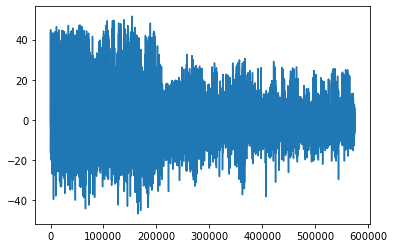

In [17]:
plt.plot(f0)

In [18]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(574902, 184446) 93 61203


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [19]:
import time
from scipy.optimize import least_squares

In [20]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6469e+06                                    1.66e+07    
       1              3         3.4755e+06      2.17e+06       3.40e+00       3.23e+07    
       2              6         3.4158e+06      5.97e+04       5.37e-01       3.97e+07    
       3              8         3.3411e+06      7.47e+04       1.42e-01       4.16e+07    
       4              9         3.3131e+06      2.80e+04       2.69e-01       4.56e+07    
       5             10         3.2978e+06      1.53e+04       2.72e-01       4.97e+07    
       6             11         3.2952e+06      2.64e+03       6.92e-02       5.08e+07    
       7             12         3.2946e+06      5.92e+02       1.74e-02       5.11e+07    
       8             13         3.2944e+06      1.44e+02       4.35e-03       5.11e+07    
       9             14         3.2944e+06      3.56e+01       1.09e-03       5.12e+07    

In [21]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [22]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [23]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 67 seconds


Now let's plot residuals at the found solution:

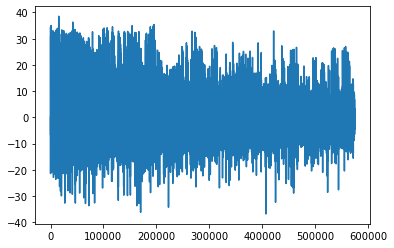

In [24]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: In practical setting  we can correlate each image with a camera pose. As a result, there is a correspondence between the picture and the camera pose. We may extend this correspondence to the image coordinates because the points recorded in points 2d are from the image. Typically, these images are obtained through a feature extractor such as SIFT.



    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: In practical settings, we know that images in different perspectives are captured at different positions. We can use SIFT/SURF or ORB to determine corresponding points between two photos using this information. After this  8-point algorithm estimates the Fundamental Matrix, from which we may obtain the Essential Matrix and decompose it into R,t, and K. To obtain 3D coordinates, we can now triangulate or backproject points to the world. As a result, we now have our 2D-3D correspondences.


    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: Rodrigue's formula defines rotation of a point $P$ as $P$ being rotated by an angle $theta$ about a fixed axis $n$. 
    This is distinct from our usual Rotation matrix, in which we convert a point by multiplying it by a 3x3 rotation matrix (R). 
    So, in the instance of Rodrigue, we don't require a 3x3 matrix
    We only need minimum three parameters : two for the rotation vector  and one for theta. (the third can be computed from the other two because this vector is a unit vector).
    We do this because we have a camera params matrix (3x3) with 9 parameters in this example (including the 3 parameters required for rotation by rodrigues). 
    We were given a 3x4 projection matrix with a total of 12 parameters in our lesson (this is because it contains R,t and K). 
    So in all, we have $9*n cameras$ parameters to estimate in this scenario, but in the case of a 3x3 rotation matrix, we have $12*n cameras$ parameters to estimate.
    
    $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Yes, there could be a distinction. Translation precedes rotation, implying that we move to a different origin first and then rotate about that origin. When we translate after rotating, we are also moving the rotation centre.
    If the translation vector is in the camera frame, the point must first be rotated to the camera frame before being added to the translation vector; otherwise, the translation vector and the point would be in different frames.


        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian : As every row in Jacobian corresponds to a residue, we have as many rows as no. of residuals and that is equal to the total no. of 2d points we have as the loss function measures the diff between reporjected 2d points calc from estimated 3d points and estimated parameters and obs 2d points from image.
    Now because each 2d point contributes 2 coordinates and not one i.e x and y , so we have twice as many residuals as the number of 2d points.
    And it is different from class because in class we have assumed each N point is visible in M images so it leaves us with MN 2d points.Here however we have camera_indices.size 2d points as each element in camera_indices maps 2d point to image so twice as many rows or residuals in jacobian.
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1: Jacobian & Parameters: We used the homogeneous transformation matrix of dimensions 3x4 in the lecture, which gave us 12 unknowns for each camera. This matrix combines the intrinsics and the extrinsics (rotation and translation) into a single matrix, and we just optimise for it. 
        In this case, we segregated the various parameters by utilising distinct equations to describe the individual parts. 
        We employed one equation for the extrinsics, which included three rotation parameters and three translation parameters, and one equation for the intrinsics, which included three parameters (1 focal length + two radial distortion). 
        We optimised for each of these factors as a separate entity, resulting in just 9 unknowns per camera.   
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2: Jacobian and Parameters: We had `n points * 3 + n cameras * 12` unknowns in the lecture and   we have `n cameras * 9 + n points * 3` unknowns in the code.
        we have `n cameras * 9 + n points * 3` unknowns in the code. The primary difference here is the quantity of unknowns associated with the poses/camera frames. 
        In the lecture, we avoided optimising over the SO(3) manifold by optimising over the projection matrix of dimensions 3x4 and only required to explicitly estimate the 12 projection parameters, which comprised both extrinsics and intrinsics in a single matrix. In contrast, we model the extrinsics and intrinsics independently in this case, employing a rotation vector (3), a translation vector (3), and three extra parameters of focal length (1) and radial distortion (2), totaling nine unknowns for each view of the camera.         
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 
- This code essentially initialises the sparse Jacobian by designating non-zero items as 1 and leaving the remainder as 0.
- For each of the two rows of each observation/2D image point, the 9 columns of the corresponding camera parameters and the 3 columns of the corresponding 3D point are set to one.
- Because they have no effect on the observation, the remaining values/columns are set to 0.  The next for loop sets 3 cols corresponding to the world point in the ith observation to 1 for all i. Other elements remain 0 and form a sparse structure.
- Each column in the Jacobian represents an unknown parameter being optimised, whereas each row represents an observation/equation. Because each observation/2D point has two equations, one for the x and one for the y, we have 2 * num obs rows. Because we have (n cameras * 9 + n points * 3) unknowns, the Jacobian has (n cameras * 9 + n points * 3) columns.
- The distinction is that in our lecture notes, we used M for the number of photos and N for the number of points in each image, and we had MN 2D points, each with two coordinates, resulting in 2MN residuals for the Jacobian rows. 
- m has a distinct size since it contains information about all of the observation made collectively (all 2D points), i.e., 'camera indices.size' 2D points.
- In lectures, residuals were arranged first by points and then by pictures, but here they appear in no particular sequence, which has no effect if order is maintained along the pipeline.


In [1]:
import numpy as np 
from scipy.sparse import lil_matrix

n_camera = 3
n_point = 3
camera_iter=np.arange(n_camera)
camera_idx = np.array([camera_iter]*n_point)
camera_idx=camera_idx.T.flatten()
point_iter=np.arange(n_point)
point_idx = np.array([point_iter]*n_camera)
point_idx=point_idx.flatten()

print("camera_idx = ",camera_idx,end="\n")
print("point_idx = ", point_idx,end="\n")

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = 2* camera_indices.size 
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1
    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
    return A

print("Sparse Jacobian is :")
J=bundle_adjustment_sparsity(n_camera, n_point, camera_idx, point_idx)
print(J)


camera_idx =  [0 0 0 1 1 1 2 2 2]
point_idx =  [0 1 2 0 1 2 0 1 2]
Sparse Jacobian is :
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 27)	1
  (0, 28)	1
  (0, 29)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 27)	1
  (1, 28)	1
  (1, 29)	1
  (2, 0)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	1
  (2, 4)	1
  (2, 5)	1
  (2, 6)	1
  (2, 7)	1
  (2, 8)	1
  (2, 27)	1
  (2, 28)	1
  (2, 29)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
  (3, 3)	1
  (3, 4)	1
  (3, 5)	1
  (3, 6)	1
  (3, 7)	1
  (3, 8)	1
  (3, 27)	1
  (3, 28)	1
  (3, 29)	1
  (4, 0)	1
  (4, 1)	1
  (4, 2)	1
  (4, 3)	1
  (4, 4)	1
  (4, 5)	1
  (4, 6)	1
  (4, 7)	1
  (4, 8)	1
  (4, 27)	1
  (4, 28)	1
  (4, 29)	1
  (5, 0)	1
  (5, 1)	1
  (5, 2)	1
  (5, 3)	1
  (5, 4)	1
  (5, 5)	1
  (5, 6)	1
  (5, 7)	1
  (5, 8)	1
  (5, 27)	1
  (5, 28)	1
  (5, 29)	1
  (6, 9)	1
  (6, 10)	1
  (6, 11)	1
  (6, 12)	1
  (6, 13)	1
  (6, 14)	1
  (6, 15)	1
  (6, 16)	1
  (6, 1

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

*Answer2.* 
Given: 2 images and K matrix 
1. **First we do feature matching** 
For doing this we will create an instance of ORB detector class (in openCV ofc) with the help of `cv2.ORB_create()`. 
Then we use `detectAndCompute()` as a fuction to detector for extracting ORB features which constitues descriptors as well as keypoints on both images.(we pass none for showing we are not passing the features that are predefined) 

    ``` orb=cv2.ORB_create() ``` 
    ``` Keypoint1,descriptor1=orb.detectAndCompute(image1,None) ``` 
    ``` Keypoint2,descriptor2=orb.detectAndCompute(image2,None) ``` 

2. After this , we need to do **matching of the keypoints from the two images.** 
For doing this we will create brute-force matcher with the help of `cv2.BFMatcher()` 
Then with the help of ORB descriptors we will perform KNN matching with the help of `knnMatch()` 
And now we have the matching features from both the images. 

    ```brute_force=cv2.BFMatcher() ```
    ```Matches=brute_force.knnMatch(descriptor1,descriptor2,k=2) ```

    [we can also use ```brute_force.match(descriptor1,descriptor2)```]

3. From the above two steps, we have matched features from both the images. Now with the help of these matches, we find fundamental matrix with the help of cv2.finfFundamentalMat()

    [ Note: we can also use normalized 8 point algo ]

4. After we have `F` and since we know `K` we can now have the essential matrix as $ E= K^TFK $ .


Note: we can also combine points 3 and 4 in the following ways:

We can get Essential matrix directly with the help of `E=cv2.findEssentialMatrix(points1,points2,K)` Here, we input the corresponding points in the two images (points1,points2) and also the K matrix.
Now we have `E`, we can decompose it into R,t as 
`output=cv2.recoverPose(E,points1,points2,K) ` . Here we input `E` , matches `(points1,points2)` and calibration matrix `K` and gives `R` which is output[1] and `t` from output[2]. 

Then we use triangulation to initialize 3D poses and use `points_3D=cv2.triangulatePoints([points1,points2,output])` and so we get the 3D points as output !